In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from math import pi

(0.0, 1.0, 0.0, 1.0)

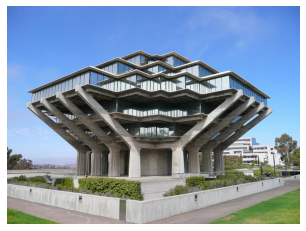

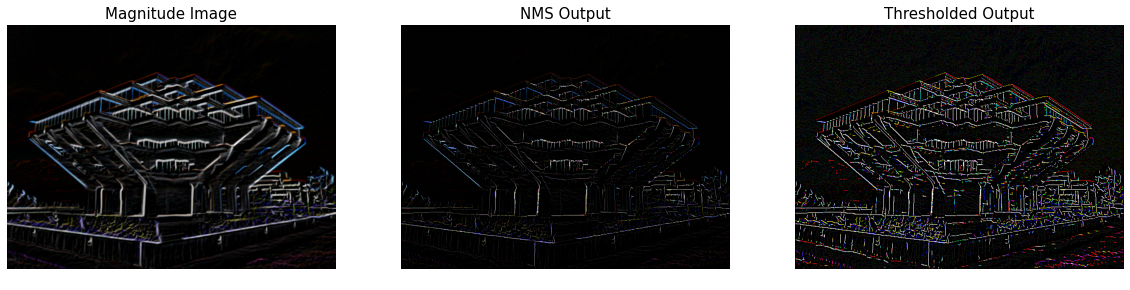

In [4]:
# Helper function to smoothen the image
def smoothen_image(image):
    local_image = np.copy(image)
    kernel = np.array([[2, 4, 5, 4, 2],
                  [4, 9, 12, 9, 4],
                  [5, 12, 15, 12, 5],
                  [4, 9, 12, 9, 4],
                  [2, 4, 5, 4, 2]])
    kernel = (1/159) * kernel
    ret_img = cv2.filter2D(src=local_image, ddepth=-1, kernel=kernel)
    return ret_img

# Helper function to find gradients
def find_gradients(image):
    kx = np.array([[-1, 0, 1], 
                   [-2, 0, 2], 
                   [-1, 0, 1]], np.float32)
    ky = np.array([[-1, -2, -1], 
                   [0, 0, 0], 
                   [1, 2, 1]], np.float32)
    
    Ix = cv2.filter2D(src=image,ddepth=-1, kernel=kx)
    Iy = cv2.filter2D(src=image, ddepth=-1, kernel=ky)
    
    #Calculate magnitude and phase of the image
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    phase = np.arctan2(Iy, Ix)
    
    return G, phase

#Non maximum suppression
def nms(image, phase):
    [rows, cols, channels] = image.shape
    ret_image = np.zeros((rows, cols, channels), dtype=np.uint8)
    #print(channels)
    for channel in range(channels):
        for i in range(1, rows - 1):
            for j in range(1, cols - 1):
                max_x = 255
                max_y = 255
                if (0 <= phase[i,j,channel] < 22.5) or (157.5 <= phase[i,j,channel] <= 180):
                    max_x = image[i, j+1,channel]
                    max_y = image[i, j-1,channel]
                elif (22.5 <= phase[i,j,channel] < 67.5):
                    max_x = image[i+1, j-1,channel]
                    max_y = image[i-1, j+1,channel]
                elif (67.5 <= phase[i,j,channel] < 112.5):
                    max_x = image[i+1, j,channel]
                    max_y = image[i-1, j,channel]
                elif (112.5 <= phase[i,j,channel] < 157.5):
                    max_x = image[i-1, j-1,channel]
                    max_y = image[i+1, j+1,channel]


                if (image[i,j,channel] >= max_x) and (image[i,j,channel] >= max_y):
                    ret_image[i,j,channel] = image[i,j,channel]
                else:
                    ret_image[i,j,channel] = 0
    return ret_image

#Helper function to threshold, double thresholding is used for better results
def threshold(image, lower, higher):
    high = image.max() * higher;
    low = higher * lower;
    
    [rows, cols, ch]= image.shape
    ret_image = np.zeros((rows,cols, ch), dtype=np.int32)
    
    weak = np.uint8(25)
    strong = np.uint8(255)
    strong_i, strong_j, strong_ch = np.where(image >= high)
    zeros_i, zeros_j, zeros_ch = np.where(image < low)
    weak_i, weak_j, weak_ch = np.where((image <= high) & (image >= low))
   
    ret_image[strong_i, strong_j, strong_ch] = strong
    #ret_image[ret_image>=high] = strong
    ret_image[weak_i, weak_j, weak_ch] = weak
    
    return (ret_image, weak, strong)

#Main function that performs canny edge detection
def canny_detector(image):
    # Image smoothing
    smooth_image = smoothen_image(image)
    
    #Gradient finding
    mag, phase = find_gradients(smooth_image)
    mag = mag.astype(np.uint8)  # Converting magnitude to an integer matrix
    phase = (phase*180)/(2*pi)  # Converting phase to angle from radians
    phase[phase<0] += 180 # Cycling the negative phases
    
    #Non-Maximum suppression
    nms_image = nms(mag, phase)
    
    #Thresholding
    ret_image, weak, strong = threshold(nms_image, 0.05, 0.09)
    
    return mag, nms_image, ret_image   


geisel = cv2.imread("geisel.jpg")
geisel = cv2.cvtColor(geisel, cv2.COLOR_BGR2RGB)
plt.imshow(geisel)
plt.axis("off")

mag, nms_image, ret_image = canny_detector(geisel)

fig, axs = plt.subplots(1,3, figsize=(20, 5))
ax1= fig.add_subplot(1,3,1)
ax1.title.set_text("Magnitude Image")
ax1.title.set_size(15)
ax1.axis('off')
ax1.imshow(mag)
axs[0].axis('off')

ax1= fig.add_subplot(1,3,2)
ax1.title.set_text("NMS Output")
ax1.title.set_size(15)
ax1.axis('off')
ax1.imshow(nms_image)
axs[1].axis('off')

ax1= fig.add_subplot(1,3,3)
ax1.title.set_text("Thresholded Output")
ax1.title.set_size(15)
ax1.axis('off')
ax1.imshow(ret_image)
axs[2].axis('off')

